In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
from neural_process import NeuralProcess

from load_data import *
from utils import *
from vae import *
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from training import *
from agents import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
movie_features = load__movies_info()
user_features = load_users_info()
user_movie_ratings = load_user_movie_rating()
avg_score = user_movie_ratings.groupby("movie id").mean()['rating'].sort_values(ascending=False)
movie_features=pd.merge(movie_features,avg_score,on="movie id")

In [3]:
movies = postprocess_movie(movie_features)
users  = postprocess_user(user_features)

In [4]:
U_Mat = utility_matrix(user_movie_ratings)

In [7]:
movies[:, -1] = movies[:, -1] /5.0 

In [9]:
user_features

,user id,age,gender,occupation,zip code
0,1,24,1,19,85711
1,2,53,0,13,94043
2,3,23,1,20,32067
3,4,24,1,19,43537
4,5,33,0,13,15213
...,...,...,...,...,...
938,939,26,0,18,33319
939,940,32,1,0,02215
940,941,20,1,18,97229
941,942,48,0,10,78209


In [40]:
training_dataset = UserMovieTrainDataset(U_Mat, users, movies)
testing_dataset = UserMovieTestDataset(U_Mat, users, movies)

In [41]:
x_dim = 23
y_dim = 1
r_dim = 100  # Dimension of representation of context points
z_dim = 100  # Dimension of sampled latent variable
h_dim = 100  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

In [42]:
# pretraining
batch_size = 1
num_context = 10
num_target = 20

training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_dataloader = DataLoader(testing_dataset, batch_size=1)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=5e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200)

neuralprocess.training = True
np_trainer.train(training_dataloader, 30)

iteration 200, loss 34.797
iteration 400, loss 45.293
iteration 600, loss 41.985
iteration 800, loss 49.708
Epoch: 0, Avg_loss: 51.004279936548045
iteration 1000, loss 63.238
iteration 1200, loss 47.888
iteration 1400, loss 37.594
iteration 1600, loss 37.638
Epoch: 1, Avg_loss: 43.16477562198447
iteration 1800, loss 45.972
iteration 2000, loss 32.772
iteration 2200, loss 43.359
iteration 2400, loss 42.507
iteration 2600, loss 44.281
Epoch: 2, Avg_loss: 42.65966888931804
iteration 2800, loss 56.071
iteration 3000, loss 32.559
iteration 3200, loss 32.456
iteration 3400, loss 49.541
Epoch: 3, Avg_loss: 42.433023557417336
iteration 3600, loss 40.741
iteration 3800, loss 33.760
iteration 4000, loss 44.486
iteration 4200, loss 46.690
iteration 4400, loss 28.137
Epoch: 4, Avg_loss: 42.00500083103159
iteration 4600, loss 36.773
iteration 4800, loss 39.455
iteration 5000, loss 40.911
iteration 5200, loss 43.084
Epoch: 5, Avg_loss: 41.61162263842473
iteration 5400, loss 29.418
iteration 5600, lo

In [45]:
torch.save(neuralprocess.state_dict(), 'weights/pretain_iter_30_dim_100_lr_5e-4.pth')

In [44]:
def load_weights(model, path):
    model.load_state_dict(torch.load(path))

/Users/lx1030/Desktop/CSE291DRL_FINAL_PROJECT


In [99]:
#refining
batch_size = 1

training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=5e-5)
np_trainer = MovieNPTrainer(device, neuralprocess, optimizer)

neuralprocess.training = True
np_trainer.train(training_dataloader, 10)

iteration 100, loss 47.981
iteration 200, loss 30.383
iteration 300, loss 47.898
iteration 400, loss 43.644
iteration 500, loss 85.883
iteration 600, loss 72.742
no safe initialization possible
iteration 700, loss 83.982
iteration 800, loss 40.947
Epoch: 0, Avg_loss: 56.15898701538564
iteration 900, loss 64.330
iteration 1000, loss 42.431
no safe initialization possible
iteration 1100, loss 62.505
iteration 1200, loss 60.104
iteration 1300, loss 59.788
iteration 1400, loss 60.364
iteration 1500, loss 57.171
iteration 1600, loss 63.390
iteration 1700, loss 24.639
Epoch: 1, Avg_loss: 56.06179232880356
iteration 1800, loss 23.130
iteration 1900, loss 38.283
no safe initialization possible
iteration 2000, loss 46.610
iteration 2100, loss 53.675
iteration 2200, loss 67.460
iteration 2300, loss 40.674
iteration 2400, loss 48.447
iteration 2500, loss 49.444
iteration 2600, loss 51.782
Epoch: 2, Avg_loss: 56.15247425707297
iteration 2700, loss 58.619
iteration 2800, loss 45.821
iteration 2900,

In [46]:
def context_rest_split(x, y, num_context):
    num_points = x.shape[1]

    # Sample locations of context and target points
    indices = [i for i in range(num_points)]
    locations = sorted(random.sample(indices,num_context))
    rest_locations = sorted([i for i in indices if i not in locations])

    x_context = x[:, locations, :]
    y_context = y[:, locations, :]
    x_rest = x[:, rest_locations, :]
    y_rest = y[:, rest_locations, :]

    return x_context, y_context, locations, x_rest, y_rest, rest_locations

In [47]:
x, y = testing_dataset[3]
x_context, y_context, locations, x_rest, y_rest, rest_locations = context_rest_split(x.unsqueeze(0), y.unsqueeze(0), 5)
x.shape

torch.Size([22, 23])

In [48]:
neuralprocess.training = False
for i in range(64):
    p_y_pred = neuralprocess(x_context, y_context, x_rest)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    sigma = p_y_pred.scale.detach()
    break

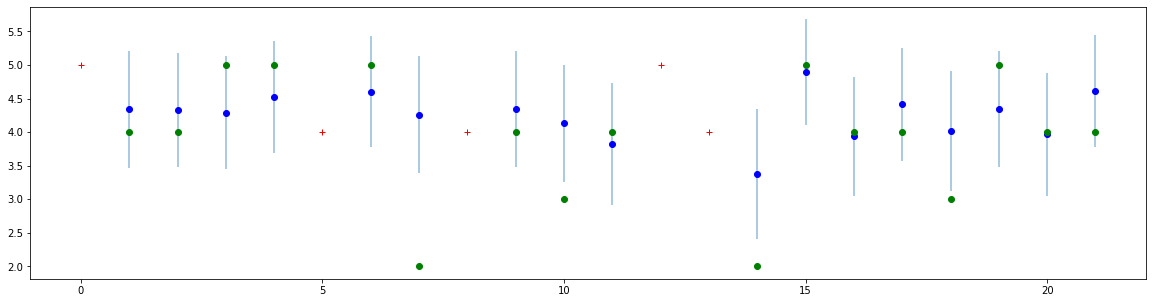

In [49]:
plt.rcParams['figure.figsize'] = 20, 5

mu = mu.numpy().squeeze()
sigma = sigma.numpy().squeeze()
plt.plot(locations, y_context.numpy().squeeze(), 'r+')
plt.plot(rest_locations, mu, 'bo')
plt.plot(rest_locations, y_rest.numpy().squeeze(), 'go')
for i, idx in enumerate(rest_locations):
    plt.vlines(idx, ymin=mu[i] - sigma[i], ymax=mu[i] + sigma[i], alpha=0.5)

IndexError: too many indices for tensor of dimension 2

In [59]:
it = iter(testing_dataloader)

In [192]:
x, y = next(it)

In [193]:
x.shape, y.shape

(torch.Size([1, 107, 23]), torch.Size([1, 107, 1]))

In [260]:
npso = NeuralProcessSafeOptAgents(neuralprocess, x, y, beta=0.5, scaling=0.5)

In [261]:
for i in range(300):
    rec_x, loc = npso.optimize()
    npso.add_new_data_point(rec_x.unsqueeze(0), y[:, loc, :].unsqueeze(0), loc)

torch.Size([1, 1, 23]) torch.Size([1, 5, 23])
torch.Size([1, 1, 23]) torch.Size([1, 6, 23])
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([1, 8, 23]) torch.Size([1, 8, 1]) torch.Size([1, 7, 23])
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([1, 8, 23]) torch.Size([1, 8, 1]) torch.Size([1, 7, 23])
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([1, 8, 23]) torch.Size([1, 8, 1]) torch.Size([1, 7, 23])
ignore duplicated context
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([1, 8, 23]) torch.Size([1, 8, 1]) torch.Size([1, 11, 23])
GGGGG [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False Fals

In [245]:
np.array([3.9969286918640137])[np.newaxis, ..., np.newaxis].shape

(1, 1, 1)

In [262]:
npso.context_y

tensor([[[4.],
         [4.],
         [4.],
         [5.],
         [5.],
         [4.],
         [3.],
         [2.],
         [4.],
         [1.],
         [4.],
         [5.],
         [5.],
         [5.],
         [4.],
         [2.],
         [3.],
         [4.],
         [3.],
         [3.],
         [4.],
         [5.]]])

In [163]:
rec_x

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  3.8840, 24.0000,  1.0000, 19.0000]])

In [162]:
npso.context_loc

[3, 5, 8, 11, 16]

In [147]:
npso.Q

array([[2.8875978 , 2.91326308, 2.93135285, 2.94414783, 3.15109372,
        2.72542238, 3.266819  , 2.86887932, 2.92226219, 2.91787982,
        2.72226238, 2.38741565, 2.95993567, 2.87167358, 1.89623296,
        3.59902811, 2.52627277, 3.02766085, 2.59576702, 2.94915962,
        2.47230244, 3.25549221],
       [5.33009434, 5.40063572, 5.38139725, 5.328619  , 5.55526638,
        5.15943718, 5.63528061, 5.33005333, 5.38678646, 5.40442562,
        5.20212078, 4.92666245, 5.3863349 , 5.27996159, 4.54192781,
        5.86024332, 5.02337885, 5.46066618, 5.09708881, 5.40808582,
        5.03120804, 5.64509678]])

In [151]:
y[:, 17, :]

torch.Size([1, 1])

[2, 3, 4, 17, 20]